In [7]:
import pandas as pd
import polars as pl
import xgboost as xgb 
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder
from sklearn.metrics import classification_report
from sklearn.compose import ColumnTransformer
import numpy as np
from sklearn.pipeline import Pipeline
import joblib
import xgboost as xgb
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

c:\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [8]:
dfEmpresas = pd.read_csv("../ExploracaoDados/ExtracoesBanco/DadosEmpresasParaModeloV4.csv")
dfEmpresas.fillna(0)
dfEmpresas

,CNAE FISCAL PRINCIPAL,CEP,UF,NATUREZA JURÍDICA,ANOABERTURA,QUALIFICAÇÃO DO RESPONSÁVEL,FLAGSIMPLES,FLAGMEI,POPULAÇÃO_ESTIMADA,CD_MUNIC_INT,...,PIB_2016,PIB_2017,PIB_2018,PIB_2019,PIB_2020,PIB_2021,INSS_QTD_25,INSS_VLR_25,NivelAlfabetizacao,ClassicacaoDeViabilidada
0,4744002,62500001,CE,2135,2014,50,S,N,138978.0,2306405.0,...,1329820.0,1560337.0,1649739.0,1678108.0,1644837.0,1.784007e+06,24336.0,3.897351e+08,5.0,0
1,1412601,36680000,MG,2135,2014,50,S,S,26529.0,3162906.0,...,377129.0,413804.0,395915.0,429754.0,430419.0,5.063091e+05,8213.0,1.666743e+08,3.0,1
2,1051100,95945000,RS,2062,2014,49,S,N,1771.0,4315131.0,...,43183.0,43192.0,41713.0,47514.0,50749.0,6.141942e+04,712.0,1.449646e+07,5.0,0
3,4744099,59815000,RN,2135,2014,50,S,N,1900.0,2414902.0,...,14978.0,15769.0,17668.0,20700.0,21256.0,2.323893e+04,117.0,1.732361e+06,3.0,0
4,4321500,39314000,MG,2135,2014,50,S,S,12904.0,3116159.0,...,176183.0,182547.0,199390.0,225675.0,294555.0,4.031178e+05,1602.0,2.560133e+07,3.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
881864,4789008,41610011,BA,2135,2015,50,S,S,2564204.0,2927408.0,...,61168158.0,62823699.0,63534708.0,63902294.0,58909600.0,6.295449e+07,356689.0,9.516405e+09,0.0,0
881865,3101200,76868000,RO,2135,2014,50,S,S,34149.0,1100130.0,...,512904.0,587758.0,642283.0,632997.0,700188.0,8.903204e+05,5957.0,9.646775e+07,3.0,1
881866,1412601,2452060,SP,2135,2015,50,S,S,11904961.0,3550308.0,...,683066697.0,698952189.0,714663604.0,763597808.0,746909330.0,8.289806e+08,2058994.0,6.394054e+10,1.0,1
881867,4759899,77063466,TO,2135,2014,50,S,S,328499.0,1721000.0,...,8100689.0,8503493.0,9430360.0,10455116.0,9942512.0,1.033342e+07,27179.0,5.382915e+08,2.0,1


In [9]:
dfEmpresasTrain = dfEmpresas[dfEmpresas["ANOABERTURA"] < 2020]
dfEmpresasTest = dfEmpresas[dfEmpresas["ANOABERTURA"] > 2020]
dfEmpresasTest21 = dfEmpresasTest[dfEmpresasTest["ANOABERTURA"] == 2021]
dfEmpresasTest22 = dfEmpresasTest[dfEmpresasTest["ANOABERTURA"] == 2022]
dfEmpresasTest23 = dfEmpresasTest[dfEmpresasTest["ANOABERTURA"] == 2023]
dfEmpresasTest24 = dfEmpresasTest[dfEmpresasTest["ANOABERTURA"] == 2024]
dfEmpresasTest25 = dfEmpresasTest[dfEmpresasTest["ANOABERTURA"] == 2025]


In [10]:
dfEmpresasTrain = dfEmpresasTrain.drop("ANOABERTURA", axis=1)
dfEmpresasTest = dfEmpresasTest.drop("ANOABERTURA", axis=1)
dfEmpresasTest21 = dfEmpresasTest21.drop("ANOABERTURA", axis=1)
dfEmpresasTest22 = dfEmpresasTest22.drop("ANOABERTURA", axis=1)
dfEmpresasTest23 = dfEmpresasTest23.drop("ANOABERTURA", axis=1)
dfEmpresasTest24 = dfEmpresasTest24.drop("ANOABERTURA", axis=1)
dfEmpresasTest25 = dfEmpresasTest25.drop("ANOABERTURA", axis=1)


In [11]:
XTrain = dfEmpresasTrain.drop("ClassicacaoDeViabilidada", axis=1)
YTrain = dfEmpresasTrain["ClassicacaoDeViabilidada"]

XTest21 = dfEmpresasTest21.drop("ClassicacaoDeViabilidada", axis=1)
YTest21 = dfEmpresasTest21["ClassicacaoDeViabilidada"]

XTest22 = dfEmpresasTest22.drop("ClassicacaoDeViabilidada", axis=1)
YTest22 = dfEmpresasTest22["ClassicacaoDeViabilidada"]

XTest23 = dfEmpresasTest23.drop("ClassicacaoDeViabilidada", axis=1)
YTest23 = dfEmpresasTest23["ClassicacaoDeViabilidada"]

XTest24 = dfEmpresasTest24.drop("ClassicacaoDeViabilidada", axis=1)
YTest24 = dfEmpresasTest24["ClassicacaoDeViabilidada"]

XTest25 = dfEmpresasTest25.drop("ClassicacaoDeViabilidada", axis=1)
YTest25 = dfEmpresasTest25["ClassicacaoDeViabilidada"]


In [ ]:
transformers = ColumnTransformer(
    transformers=[
        ("UF", OrdinalEncoder(), ["UF"]),
        ("FLAGSIMPLES", OrdinalEncoder(), ["FLAGSIMPLES"]),
        ("FLAGMEI", OrdinalEncoder(), ["FLAGMEI"])
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)

In [ ]:

def objective(trial):
    model_name = trial.suggest_categorical('model', ['xgboost', 'lightgbm', 'catboost', 'random_forest'])

    if model_name == 'xgboost':
        model = xgb.XGBClassifier(
            learning_rate=trial.suggest_float('xgb_lr', 0.01, 0.3),
            n_estimators=trial.suggest_int('xgb_n_estimators', 50, 200),
            max_depth=trial.suggest_int('xgb_max_depth', 3, 10),
            subsample=trial.suggest_float('xgb_subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('xgb_colsample_bytree', 0.5, 1.0),
            use_label_encoder=False,
            eval_metric='mlogloss'
        )

    elif model_name == 'lightgbm':
        model = lgb.LGBMClassifier(
            learning_rate=trial.suggest_float('lgb_lr', 0.01, 0.3),
            n_estimators=trial.suggest_int('lgb_n_estimators', 50, 200),
            num_leaves=trial.suggest_int('lgb_num_leaves', 20, 100),
            subsample=trial.suggest_float('lgb_subsample', 0.5, 1.0),
            colsample_bytree=trial.suggest_float('lgb_colsample_bytree', 0.5, 1.0)
        )

    elif model_name == 'catboost':
        model = CatBoostClassifier(
            learning_rate=trial.suggest_float('cat_lr', 0.01, 0.3),
            iterations=trial.suggest_int('cat_iterations', 50, 200),
            depth=trial.suggest_int('cat_depth', 4, 10),
            verbose=0
        )

    else:
        model = RandomForestClassifier(
            n_estimators=trial.suggest_int('rf_n_estimators', 50, 200),
            max_depth=trial.suggest_int('rf_max_depth', 3, 15),
            min_samples_split=trial.suggest_int('rf_min_samples_split', 2, 10),
            min_samples_leaf=trial.suggest_int('rf_min_samples_leaf', 1, 5)
        )

    pipeline = Pipeline([
        ('preprocessor', transformers),
        ('classifier', model)
    ])

    cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = cross_val_score(pipeline, XTrain, YTrain, cv=cv, scoring='f1_weighted', n_jobs=-1)

    return scores.mean()


# Rodar o Optuna
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100, show_progress_bar=True)

# Resultados
print("Melhor valor (F1 médio):", study.best_value)
print("Melhores parâmetros:", study.best_params)

[I 2025-10-23 09:15:06,346] A new study created in memory with name: no-name-3bc353f5-33d8-4f96-aa05-5cfdb60a2ab0
Best trial: 0. Best value: 0.600739:   1%|          | 1/100 [00:11<19:00, 11.52s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:15:17,862] Trial 0 finished with value: 0.6007388890690287 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.034332924243363046, 'lgb_n_estimators': 178, 'lgb_num_leaves': 71, 'lgb_subsample': 0.794098465795521, 'lgb_colsample_bytree': 0.6641497829098226}. Best is trial 0 with value: 0.6007388890690287.


Best trial: 1. Best value: 0.618636:   2%|▏         | 2/100 [03:57<3:45:19, 137.96s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:19:04,329] Trial 1 finished with value: 0.6186361003286942 and parameters: {'model': 'xgboost', 'xgb_lr': 0.26053531305916006, 'xgb_n_estimators': 170, 'xgb_max_depth': 9, 'xgb_subsample': 0.8992700269490258, 'xgb_colsample_bytree': 0.8557256044147354}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:   3%|▎         | 3/100 [05:39<3:16:28, 121.53s/it]

[I 2025-10-23 09:20:46,302] Trial 2 finished with value: 0.6129697485353901 and parameters: {'model': 'xgboost', 'xgb_lr': 0.22416315656177524, 'xgb_n_estimators': 126, 'xgb_max_depth': 8, 'xgb_subsample': 0.9388355146223788, 'xgb_colsample_bytree': 0.621792545489664}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:   4%|▍         | 4/100 [05:47<2:02:18, 76.44s/it] 

[I 2025-10-23 09:20:53,635] Trial 3 finished with value: 0.6108906819196377 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.1336350526891463, 'lgb_n_estimators': 179, 'lgb_num_leaves': 59, 'lgb_subsample': 0.9881012287208818, 'lgb_colsample_bytree': 0.7566811714381119}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:   5%|▌         | 5/100 [05:53<1:20:42, 50.97s/it]

[I 2025-10-23 09:20:59,439] Trial 4 finished with value: 0.6139876800532628 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.25186870179207876, 'lgb_n_estimators': 136, 'lgb_num_leaves': 91, 'lgb_subsample': 0.6771497474930179, 'lgb_colsample_bytree': 0.5788952378883506}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:   6%|▌         | 6/100 [06:54<1:25:35, 54.63s/it]

[I 2025-10-23 09:22:01,172] Trial 5 finished with value: 0.5263280481148213 and parameters: {'model': 'random_forest', 'rf_n_estimators': 102, 'rf_max_depth': 9, 'rf_min_samples_split': 2, 'rf_min_samples_leaf': 2}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:   7%|▋         | 7/100 [08:14<1:37:26, 62.86s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:23:20,984] Trial 6 finished with value: 0.5159788645850732 and parameters: {'model': 'random_forest', 'rf_n_estimators': 183, 'rf_max_depth': 6, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 3}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:   8%|▊         | 8/100 [09:44<1:49:35, 71.48s/it]

[I 2025-10-23 09:24:50,901] Trial 7 finished with value: 0.6071519675711032 and parameters: {'model': 'xgboost', 'xgb_lr': 0.24717716330980985, 'xgb_n_estimators': 104, 'xgb_max_depth': 6, 'xgb_subsample': 0.8494302681761714, 'xgb_colsample_bytree': 0.7603833457080655}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:   9%|▉         | 9/100 [09:53<1:18:32, 51.79s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:24:59,404] Trial 8 finished with value: 0.6043713811280548 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.06033361305682455, 'lgb_n_estimators': 129, 'lgb_num_leaves': 90, 'lgb_subsample': 0.9772482297428536, 'lgb_colsample_bytree': 0.8043895141710886}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:  10%|█         | 10/100 [13:37<2:37:47, 105.19s/it]

[I 2025-10-23 09:28:44,165] Trial 9 finished with value: 0.5975048111415581 and parameters: {'model': 'xgboost', 'xgb_lr': 0.03281657172009664, 'xgb_n_estimators': 150, 'xgb_max_depth': 9, 'xgb_subsample': 0.9667614761369742, 'xgb_colsample_bytree': 0.9631428056672962}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:  11%|█         | 11/100 [13:50<1:53:51, 76.75s/it] 

[I 2025-10-23 09:28:56,445] Trial 10 finished with value: 0.5329032508656472 and parameters: {'model': 'catboost', 'cat_lr': 0.021671772627656433, 'cat_iterations': 144, 'cat_depth': 5}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:  12%|█▏        | 12/100 [14:04<1:24:39, 57.72s/it]

[I 2025-10-23 09:29:10,646] Trial 11 finished with value: 0.5939366173758598 and parameters: {'model': 'catboost', 'cat_lr': 0.2765802069745725, 'cat_iterations': 55, 'cat_depth': 10}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 1. Best value: 0.618636:  13%|█▎        | 13/100 [14:07<59:58, 41.36s/it]  c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:29:14,343] Trial 12 finished with value: 0.6036802675090546 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.29755119779798733, 'lgb_n_estimators': 67, 'lgb_num_leaves': 21, 'lgb_subsample': 0.5036171134097372, 'lgb_colsample_bytree': 0.5088108438809911}. Best is trial 1 with value: 0.6186361003286942.


Best trial: 13. Best value: 0.620142:  14%|█▍        | 14/100 [19:47<3:08:24, 131.44s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:34:53,948] Trial 13 finished with value: 0.6201423464338054 and parameters: {'model': 'xgboost', 'xgb_lr': 0.287707726752233, 'xgb_n_estimators': 197, 'xgb_max_depth': 10, 'xgb_subsample': 0.5882783950860055, 'xgb_colsample_bytree': 0.9138732925253983}. Best is trial 13 with value: 0.6201423464338054.


Best trial: 14. Best value: 0.620236:  15%|█▌        | 15/100 [25:23<4:33:41, 193.20s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:40:30,267] Trial 14 finished with value: 0.620236369268062 and parameters: {'model': 'xgboost', 'xgb_lr': 0.29911719420062916, 'xgb_n_estimators': 197, 'xgb_max_depth': 10, 'xgb_subsample': 0.5778214696380668, 'xgb_colsample_bytree': 0.9160310065717772}. Best is trial 14 with value: 0.620236369268062.


Best trial: 14. Best value: 0.620236:  16%|█▌        | 16/100 [27:07<3:52:40, 166.20s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:42:13,754] Trial 15 finished with value: 0.6045838593649595 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2931246593092955, 'xgb_n_estimators': 195, 'xgb_max_depth': 3, 'xgb_subsample': 0.5401101613480676, 'xgb_colsample_bytree': 0.9899651830611443}. Best is trial 14 with value: 0.620236369268062.


Best trial: 14. Best value: 0.620236:  17%|█▋        | 17/100 [28:49<3:23:09, 146.86s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:43:55,640] Trial 16 finished with value: 0.6099350865764077 and parameters: {'model': 'xgboost', 'xgb_lr': 0.16719574465430465, 'xgb_n_estimators': 59, 'xgb_max_depth': 10, 'xgb_subsample': 0.5788640335379314, 'xgb_colsample_bytree': 0.8463621761536094}. Best is trial 14 with value: 0.620236369268062.


Best trial: 14. Best value: 0.620236:  18%|█▊        | 18/100 [32:25<3:49:09, 167.68s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:47:31,801] Trial 17 finished with value: 0.6175812418141103 and parameters: {'model': 'xgboost', 'xgb_lr': 0.29591886506785037, 'xgb_n_estimators': 200, 'xgb_max_depth': 7, 'xgb_subsample': 0.6826658348749587, 'xgb_colsample_bytree': 0.8862779638831801}. Best is trial 14 with value: 0.620236369268062.


Best trial: 14. Best value: 0.620236:  19%|█▉        | 19/100 [35:10<3:45:16, 166.87s/it]

[I 2025-10-23 09:50:16,782] Trial 18 finished with value: 0.6167420507265639 and parameters: {'model': 'xgboost', 'xgb_lr': 0.17251431188870187, 'xgb_n_estimators': 167, 'xgb_max_depth': 10, 'xgb_subsample': 0.6660341977824775, 'xgb_colsample_bytree': 0.5086393581738566}. Best is trial 14 with value: 0.620236369268062.


Best trial: 14. Best value: 0.620236:  20%|██        | 20/100 [35:55<2:53:53, 130.41s/it]

[I 2025-10-23 09:51:02,226] Trial 19 finished with value: 0.5783451635427892 and parameters: {'model': 'random_forest', 'rf_n_estimators': 55, 'rf_max_depth': 15, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 5}. Best is trial 14 with value: 0.620236369268062.


Best trial: 14. Best value: 0.620236:  21%|██        | 21/100 [36:21<2:10:27, 99.09s/it] c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:51:28,273] Trial 20 finished with value: 0.599129134113436 and parameters: {'model': 'catboost', 'cat_lr': 0.116454881255377, 'cat_iterations': 185, 'cat_depth': 9}. Best is trial 14 with value: 0.620236369268062.


Best trial: 21. Best value: 0.62174:  22%|██▏       | 22/100 [40:59<3:18:35, 152.76s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 09:56:06,212] Trial 21 finished with value: 0.6217397710318058 and parameters: {'model': 'xgboost', 'xgb_lr': 0.29620855288081605, 'xgb_n_estimators': 178, 'xgb_max_depth': 10, 'xgb_subsample': 0.788348923867951, 'xgb_colsample_bytree': 0.862530299004002}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  23%|██▎       | 23/100 [46:20<4:20:49, 203.23s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:01:27,167] Trial 22 finished with value: 0.620979762693436 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2970332023609205, 'xgb_n_estimators': 188, 'xgb_max_depth': 10, 'xgb_subsample': 0.7888796488238002, 'xgb_colsample_bytree': 0.9143494150340133}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  24%|██▍       | 24/100 [49:54<4:21:15, 206.25s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:05:00,467] Trial 23 finished with value: 0.6161972800107254 and parameters: {'model': 'xgboost', 'xgb_lr': 0.22040413102341738, 'xgb_n_estimators': 174, 'xgb_max_depth': 8, 'xgb_subsample': 0.8180295899376031, 'xgb_colsample_bytree': 0.7818272708149023}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  25%|██▌       | 25/100 [54:45<4:49:54, 231.93s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:09:52,295] Trial 24 finished with value: 0.6134674591676671 and parameters: {'model': 'xgboost', 'xgb_lr': 0.09912545013752529, 'xgb_n_estimators': 147, 'xgb_max_depth': 10, 'xgb_subsample': 0.7591604936826769, 'xgb_colsample_bytree': 0.9255313570605673}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  26%|██▌       | 26/100 [56:39<4:02:07, 196.32s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:11:45,523] Trial 25 finished with value: 0.6053188667642027 and parameters: {'model': 'xgboost', 'xgb_lr': 0.25521294929840843, 'xgb_n_estimators': 181, 'xgb_max_depth': 4, 'xgb_subsample': 0.7301285236099653, 'xgb_colsample_bytree': 0.816124455317551}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  27%|██▋       | 27/100 [59:46<3:55:32, 193.59s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:14:52,757] Trial 26 finished with value: 0.6171195093485541 and parameters: {'model': 'xgboost', 'xgb_lr': 0.20840033702637997, 'xgb_n_estimators': 152, 'xgb_max_depth': 9, 'xgb_subsample': 0.807512280046409, 'xgb_colsample_bytree': 0.6892925829105376}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  28%|██▊       | 28/100 [1:04:15<4:19:38, 216.36s/it]

[I 2025-10-23 10:19:22,256] Trial 27 finished with value: 0.6187911094071236 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2995700428178458, 'xgb_n_estimators': 185, 'xgb_max_depth': 8, 'xgb_subsample': 0.7460932029445321, 'xgb_colsample_bytree': 0.9316624820847588}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  29%|██▉       | 29/100 [1:07:40<4:11:54, 212.88s/it]

[I 2025-10-23 10:22:46,989] Trial 28 finished with value: 0.5807989072117974 and parameters: {'model': 'random_forest', 'rf_n_estimators': 199, 'rf_max_depth': 15, 'rf_min_samples_split': 10, 'rf_min_samples_leaf': 1}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  30%|███       | 30/100 [1:07:47<2:56:21, 151.16s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:22:54,165] Trial 29 finished with value: 0.5803439650544447 and parameters: {'model': 'catboost', 'cat_lr': 0.28087356062526697, 'cat_iterations': 51, 'cat_depth': 4}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  31%|███       | 31/100 [1:09:28<2:36:27, 136.05s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:24:34,954] Trial 30 finished with value: 0.6072104226331504 and parameters: {'model': 'xgboost', 'xgb_lr': 0.26631862254578753, 'xgb_n_estimators': 120, 'xgb_max_depth': 5, 'xgb_subsample': 0.6643103671010471, 'xgb_colsample_bytree': 0.8720469601889469}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  32%|███▏      | 32/100 [1:16:07<4:03:42, 215.04s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:31:14,285] Trial 31 finished with value: 0.620571578532236 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2792951227559046, 'xgb_n_estimators': 199, 'xgb_max_depth': 10, 'xgb_subsample': 0.6155167563554735, 'xgb_colsample_bytree': 0.9239395540392703}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  33%|███▎      | 33/100 [1:22:53<5:03:52, 272.12s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:37:59,614] Trial 32 finished with value: 0.6198834337113563 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2651928708808972, 'xgb_n_estimators': 186, 'xgb_max_depth': 10, 'xgb_subsample': 0.5102412453509874, 'xgb_colsample_bytree': 0.9796828387456733}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  34%|███▍      | 34/100 [1:27:39<5:04:00, 276.37s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:42:45,883] Trial 33 finished with value: 0.6194438376493463 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2973622907189198, 'xgb_n_estimators': 162, 'xgb_max_depth': 9, 'xgb_subsample': 0.6352174566847187, 'xgb_colsample_bytree': 0.9026462879654327}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  35%|███▌      | 35/100 [1:32:43<5:08:16, 284.56s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:47:49,549] Trial 34 finished with value: 0.613763455420791 and parameters: {'model': 'xgboost', 'xgb_lr': 0.11047062001321828, 'xgb_n_estimators': 200, 'xgb_max_depth': 9, 'xgb_subsample': 0.7855526370231001, 'xgb_colsample_bytree': 0.8340541177316464}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  36%|███▌      | 36/100 [1:37:37<5:06:33, 287.39s/it]

[I 2025-10-23 10:52:43,553] Trial 35 finished with value: 0.6200275473876785 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2302765920320958, 'xgb_n_estimators': 182, 'xgb_max_depth': 10, 'xgb_subsample': 0.8664964349352541, 'xgb_colsample_bytree': 0.9465492679598324}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  37%|███▋      | 37/100 [1:37:43<3:33:03, 202.91s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:52:49,352] Trial 36 finished with value: 0.5995627494598863 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.1934767441664763, 'lgb_n_estimators': 54, 'lgb_num_leaves': 20, 'lgb_subsample': 0.5019771116407207, 'lgb_colsample_bytree': 0.9783991800576958}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  38%|███▊      | 38/100 [1:42:03<3:47:24, 220.07s/it]

[I 2025-10-23 10:57:09,439] Trial 37 finished with value: 0.619846765943066 and parameters: {'model': 'xgboost', 'xgb_lr': 0.27032842116052463, 'xgb_n_estimators': 187, 'xgb_max_depth': 9, 'xgb_subsample': 0.6023834016535294, 'xgb_colsample_bytree': 0.805287953059336}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  39%|███▉      | 39/100 [1:42:36<2:46:51, 164.12s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:57:43,030] Trial 38 finished with value: 0.5118253082516765 and parameters: {'model': 'random_forest', 'rf_n_estimators': 135, 'rf_max_depth': 3, 'rf_min_samples_split': 3, 'rf_min_samples_leaf': 5}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  40%|████      | 40/100 [1:44:33<2:29:55, 149.93s/it]

[I 2025-10-23 10:59:39,848] Trial 39 finished with value: 0.6134144153261626 and parameters: {'model': 'xgboost', 'xgb_lr': 0.19118137216829229, 'xgb_n_estimators': 85, 'xgb_max_depth': 10, 'xgb_subsample': 0.708332115657724, 'xgb_colsample_bytree': 0.7137569028503692}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  41%|████      | 41/100 [1:44:39<1:45:03, 106.85s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 10:59:46,166] Trial 40 finished with value: 0.6055361036335719 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.12022131020727413, 'lgb_n_estimators': 92, 'lgb_num_leaves': 48, 'lgb_subsample': 0.8167249730113126, 'lgb_colsample_bytree': 0.9897838583962418}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  42%|████▏     | 42/100 [1:51:06<3:04:33, 190.93s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:06:13,276] Trial 41 finished with value: 0.6208683460531191 and parameters: {'model': 'xgboost', 'xgb_lr': 0.27957546416309637, 'xgb_n_estimators': 196, 'xgb_max_depth': 10, 'xgb_subsample': 0.5761598543546229, 'xgb_colsample_bytree': 0.8984821795758858}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  43%|████▎     | 43/100 [1:57:27<3:55:22, 247.76s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:12:33,634] Trial 42 finished with value: 0.6199393912199497 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2755864865200287, 'xgb_n_estimators': 189, 'xgb_max_depth': 10, 'xgb_subsample': 0.5678239458857602, 'xgb_colsample_bytree': 0.8951175043939914}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  44%|████▍     | 44/100 [2:02:17<4:03:14, 260.62s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:17:24,280] Trial 43 finished with value: 0.6200274691493589 and parameters: {'model': 'xgboost', 'xgb_lr': 0.24694732487156001, 'xgb_n_estimators': 175, 'xgb_max_depth': 9, 'xgb_subsample': 0.6287745004395583, 'xgb_colsample_bytree': 0.955127047270362}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  45%|████▌     | 45/100 [2:07:54<4:19:47, 283.41s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:23:00,875] Trial 44 finished with value: 0.6208370324720119 and parameters: {'model': 'xgboost', 'xgb_lr': 0.27908578753499147, 'xgb_n_estimators': 198, 'xgb_max_depth': 10, 'xgb_subsample': 0.7719876912668622, 'xgb_colsample_bytree': 0.8784833579713043}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  46%|████▌     | 46/100 [2:11:19<3:53:52, 259.87s/it]

[I 2025-10-23 11:26:25,754] Trial 45 finished with value: 0.616981999942528 and parameters: {'model': 'xgboost', 'xgb_lr': 0.24066365828998604, 'xgb_n_estimators': 161, 'xgb_max_depth': 8, 'xgb_subsample': 0.7790332725113415, 'xgb_colsample_bytree': 0.8712080665056838}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  47%|████▋     | 47/100 [2:11:35<2:44:48, 186.58s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:26:41,383] Trial 46 finished with value: 0.5920717142737759 and parameters: {'model': 'catboost', 'cat_lr': 0.16108097434875945, 'cat_iterations': 107, 'cat_depth': 7}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  48%|████▊     | 48/100 [2:16:36<3:11:40, 221.16s/it]

[I 2025-10-23 11:31:43,218] Trial 47 finished with value: 0.6204534239754337 and parameters: {'model': 'xgboost', 'xgb_lr': 0.27599417563285433, 'xgb_n_estimators': 190, 'xgb_max_depth': 10, 'xgb_subsample': 0.8312039681525196, 'xgb_colsample_bytree': 0.871521684910084}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  49%|████▉     | 49/100 [2:16:45<2:13:44, 157.34s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:31:51,639] Trial 48 finished with value: 0.612680194618783 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.20489978957601507, 'lgb_n_estimators': 196, 'lgb_num_leaves': 38, 'lgb_subsample': 0.6564983216395776, 'lgb_colsample_bytree': 0.8633182908454755}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  50%|█████     | 50/100 [2:20:58<2:35:10, 186.20s/it]

[I 2025-10-23 11:36:05,189] Trial 49 finished with value: 0.6191629494270824 and parameters: {'model': 'xgboost', 'xgb_lr': 0.27514979069140044, 'xgb_n_estimators': 173, 'xgb_max_depth': 9, 'xgb_subsample': 0.8983425246794422, 'xgb_colsample_bytree': 0.8514978505352221}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  51%|█████     | 51/100 [2:21:44<1:57:30, 143.90s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:36:50,373] Trial 50 finished with value: 0.5353026153298823 and parameters: {'model': 'random_forest', 'rf_n_estimators': 50, 'rf_max_depth': 10, 'rf_min_samples_split': 6, 'rf_min_samples_leaf': 4}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  52%|█████▏    | 52/100 [2:27:28<2:43:19, 204.15s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:42:35,111] Trial 51 finished with value: 0.62084708714239 and parameters: {'model': 'xgboost', 'xgb_lr': 0.27556386848406556, 'xgb_n_estimators': 189, 'xgb_max_depth': 10, 'xgb_subsample': 0.8331002214724711, 'xgb_colsample_bytree': 0.8837311983235089}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  53%|█████▎    | 53/100 [2:32:51<3:07:42, 239.63s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:47:57,529] Trial 52 finished with value: 0.6202015165161237 and parameters: {'model': 'xgboost', 'xgb_lr': 0.26003826449111955, 'xgb_n_estimators': 180, 'xgb_max_depth': 10, 'xgb_subsample': 0.7830749546375397, 'xgb_colsample_bytree': 0.8950627708035854}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  54%|█████▍    | 54/100 [2:38:11<3:22:21, 263.94s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:53:18,193] Trial 53 finished with value: 0.6211060221684042 and parameters: {'model': 'xgboost', 'xgb_lr': 0.27989772395437335, 'xgb_n_estimators': 191, 'xgb_max_depth': 10, 'xgb_subsample': 0.8760957904678558, 'xgb_colsample_bytree': 0.9462947935412015}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  55%|█████▌    | 55/100 [2:43:06<3:24:49, 273.11s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 11:58:12,702] Trial 54 finished with value: 0.6194355419510641 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2502362235588688, 'xgb_n_estimators': 189, 'xgb_max_depth': 9, 'xgb_subsample': 0.8710095301998659, 'xgb_colsample_bytree': 0.9991718841850123}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  56%|█████▌    | 56/100 [2:46:08<3:00:09, 245.67s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:01:14,352] Trial 55 finished with value: 0.6146684983158006 and parameters: {'model': 'xgboost', 'xgb_lr': 0.27789640708124186, 'xgb_n_estimators': 135, 'xgb_max_depth': 7, 'xgb_subsample': 0.9175874070978346, 'xgb_colsample_bytree': 0.9592715492087674}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  57%|█████▋    | 57/100 [2:50:49<3:03:45, 256.41s/it]

[I 2025-10-23 12:05:55,816] Trial 56 finished with value: 0.5937312100900426 and parameters: {'model': 'xgboost', 'xgb_lr': 0.018407185920472274, 'xgb_n_estimators': 167, 'xgb_max_depth': 10, 'xgb_subsample': 0.8511694298884703, 'xgb_colsample_bytree': 0.8188419051802555}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  58%|█████▊    | 58/100 [2:51:15<2:11:03, 187.23s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:06:21,618] Trial 57 finished with value: 0.5331757221057655 and parameters: {'model': 'catboost', 'cat_lr': 0.010300850235551245, 'cat_iterations': 199, 'cat_depth': 7}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  59%|█████▉    | 59/100 [2:55:45<2:24:52, 212.00s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:10:51,437] Trial 58 finished with value: 0.6150537437657234 and parameters: {'model': 'xgboost', 'xgb_lr': 0.1299867558856072, 'xgb_n_estimators': 192, 'xgb_max_depth': 9, 'xgb_subsample': 0.8954661199038426, 'xgb_colsample_bytree': 0.9413420137938395}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  60%|██████    | 60/100 [2:59:44<2:26:52, 220.32s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:14:51,147] Trial 59 finished with value: 0.6187704142384846 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2858719347869634, 'xgb_n_estimators': 177, 'xgb_max_depth': 10, 'xgb_subsample': 0.992342434996411, 'xgb_colsample_bytree': 0.8612573048309295}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  61%|██████    | 61/100 [3:03:48<2:27:45, 227.33s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:18:54,836] Trial 60 finished with value: 0.6065987296688556 and parameters: {'model': 'xgboost', 'xgb_lr': 0.049762795277255883, 'xgb_n_estimators': 193, 'xgb_max_depth': 9, 'xgb_subsample': 0.8097703559025279, 'xgb_colsample_bytree': 0.7739637815497192}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  62%|██████▏   | 62/100 [3:08:37<2:35:45, 245.94s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:23:44,180] Trial 61 finished with value: 0.6203218784560867 and parameters: {'model': 'xgboost', 'xgb_lr': 0.28162267076414527, 'xgb_n_estimators': 196, 'xgb_max_depth': 10, 'xgb_subsample': 0.8441635890335547, 'xgb_colsample_bytree': 0.915216534948611}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  63%|██████▎   | 63/100 [3:13:47<2:43:26, 265.04s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:28:53,804] Trial 62 finished with value: 0.6205708478630704 and parameters: {'model': 'xgboost', 'xgb_lr': 0.28527661075194993, 'xgb_n_estimators': 199, 'xgb_max_depth': 10, 'xgb_subsample': 0.7692299591203784, 'xgb_colsample_bytree': 0.9160977983966316}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  64%|██████▍   | 64/100 [3:18:58<2:47:13, 278.72s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:34:04,445] Trial 63 finished with value: 0.6206573125275643 and parameters: {'model': 'xgboost', 'xgb_lr': 0.23572410856168163, 'xgb_n_estimators': 182, 'xgb_max_depth': 10, 'xgb_subsample': 0.7215689362575884, 'xgb_colsample_bytree': 0.9739135397206076}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  65%|██████▌   | 65/100 [3:24:09<2:48:14, 288.42s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:39:15,519] Trial 64 finished with value: 0.6199975813126838 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2359433946308228, 'xgb_n_estimators': 181, 'xgb_max_depth': 10, 'xgb_subsample': 0.7198350722620042, 'xgb_colsample_bytree': 0.973184922505751}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  66%|██████▌   | 66/100 [3:28:25<2:37:59, 278.81s/it]

[I 2025-10-23 12:43:31,910] Trial 65 finished with value: 0.6199131277095352 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2630646197730605, 'xgb_n_estimators': 171, 'xgb_max_depth': 10, 'xgb_subsample': 0.8036780798871259, 'xgb_colsample_bytree': 0.8848884714688879}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  67%|██████▋   | 67/100 [3:29:59<2:02:49, 223.32s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:45:05,749] Trial 66 finished with value: 0.5447918747672743 and parameters: {'model': 'random_forest', 'rf_n_estimators': 132, 'rf_max_depth': 11, 'rf_min_samples_split': 8, 'rf_min_samples_leaf': 1}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  68%|██████▊   | 68/100 [3:34:45<2:09:10, 242.20s/it]

[I 2025-10-23 12:49:52,012] Trial 67 finished with value: 0.6189740375020162 and parameters: {'model': 'xgboost', 'xgb_lr': 0.21184716052787803, 'xgb_n_estimators': 191, 'xgb_max_depth': 9, 'xgb_subsample': 0.7451181672217052, 'xgb_colsample_bytree': 0.9611603169928152}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  69%|██████▉   | 69/100 [3:34:51<1:28:32, 171.37s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:49:58,089] Trial 68 finished with value: 0.6040831704551387 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.08639949290978033, 'lgb_n_estimators': 98, 'lgb_num_leaves': 72, 'lgb_subsample': 0.8960058041610882, 'lgb_colsample_bytree': 0.6408536159605513}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  70%|███████   | 70/100 [3:37:18<1:21:59, 163.97s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:52:24,801] Trial 69 finished with value: 0.6136187985548759 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2910653889419088, 'xgb_n_estimators': 182, 'xgb_max_depth': 6, 'xgb_subsample': 0.8766770794068262, 'xgb_colsample_bytree': 0.8375013043607424}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  71%|███████   | 71/100 [3:40:11<1:20:36, 166.77s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 12:55:18,098] Trial 70 finished with value: 0.6192120087963903 and parameters: {'model': 'xgboost', 'xgb_lr': 0.25422800158252934, 'xgb_n_estimators': 160, 'xgb_max_depth': 10, 'xgb_subsample': 0.6974665449861839, 'xgb_colsample_bytree': 0.5688326810238272}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  72%|███████▏  | 72/100 [3:46:16<1:45:29, 226.05s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:01:22,471] Trial 71 finished with value: 0.6201944852380895 and parameters: {'model': 'xgboost', 'xgb_lr': 0.28833274076022486, 'xgb_n_estimators': 200, 'xgb_max_depth': 10, 'xgb_subsample': 0.5425266093896114, 'xgb_colsample_bytree': 0.9198144799891281}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  73%|███████▎  | 73/100 [3:51:13<1:51:21, 247.47s/it]

[I 2025-10-23 13:06:19,932] Trial 72 finished with value: 0.6206101735903246 and parameters: {'model': 'xgboost', 'xgb_lr': 0.29748046376211573, 'xgb_n_estimators': 194, 'xgb_max_depth': 10, 'xgb_subsample': 0.8265356355567459, 'xgb_colsample_bytree': 0.9367714740749915}. Best is trial 21 with value: 0.6217397710318058.


c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
Best trial: 21. Best value: 0.62174:  74%|███████▍  | 74/100 [3:57:15<2:02:03, 281.67s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:12:21,403] Trial 73 finished with value: 0.6207897866799525 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2964096108004314, 'xgb_n_estimators': 193, 'xgb_max_depth': 10, 'xgb_subsample': 0.8353766423483194, 'xgb_colsample_bytree': 0.9785628177407243}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  75%|███████▌  | 75/100 [3:58:41<1:32:55, 223.01s/it]

[I 2025-10-23 13:13:47,529] Trial 74 finished with value: 0.6028534588347975 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2634859552273757, 'xgb_n_estimators': 185, 'xgb_max_depth': 3, 'xgb_subsample': 0.8460255068301324, 'xgb_colsample_bytree': 0.9818797018434399}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  76%|███████▌  | 76/100 [3:59:02<1:05:00, 162.51s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:14:08,890] Trial 75 finished with value: 0.5972687413756153 and parameters: {'model': 'catboost', 'cat_lr': 0.1845545469138628, 'cat_iterations': 106, 'cat_depth': 8}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  77%|███████▋  | 77/100 [4:02:15<1:05:46, 171.58s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:17:21,638] Trial 76 finished with value: 0.617879942019358 and parameters: {'model': 'xgboost', 'xgb_lr': 0.288539692116744, 'xgb_n_estimators': 110, 'xgb_max_depth': 10, 'xgb_subsample': 0.934258767887878, 'xgb_colsample_bytree': 0.9951162051078892}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  78%|███████▊  | 78/100 [4:03:40<53:21, 145.55s/it]  c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:18:46,426] Trial 77 finished with value: 0.6112627117078978 and parameters: {'model': 'xgboost', 'xgb_lr': 0.299488600527553, 'xgb_n_estimators': 52, 'xgb_max_depth': 9, 'xgb_subsample': 0.7996611932083179, 'xgb_colsample_bytree': 0.9040930833082682}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  79%|███████▉  | 79/100 [4:08:44<1:07:34, 193.07s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:23:50,401] Trial 78 finished with value: 0.6213205936124604 and parameters: {'model': 'xgboost', 'xgb_lr': 0.27004775420632, 'xgb_n_estimators': 177, 'xgb_max_depth': 10, 'xgb_subsample': 0.7445142335342838, 'xgb_colsample_bytree': 0.9428382447852042}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  80%|████████  | 80/100 [4:12:53<1:09:57, 209.89s/it]

[I 2025-10-23 13:27:59,531] Trial 79 finished with value: 0.6192454645389356 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2705401374549936, 'xgb_n_estimators': 169, 'xgb_max_depth': 9, 'xgb_subsample': 0.7560312191677594, 'xgb_colsample_bytree': 0.9400783558838124}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  81%|████████  | 81/100 [4:13:25<49:34, 156.54s/it]  c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:28:31,597] Trial 80 finished with value: 0.5118253082516765 and parameters: {'model': 'random_forest', 'rf_n_estimators': 98, 'rf_max_depth': 4, 'rf_min_samples_split': 4, 'rf_min_samples_leaf': 3}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  82%|████████▏ | 82/100 [4:18:29<1:00:14, 200.81s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:33:35,683] Trial 81 finished with value: 0.6208506921619746 and parameters: {'model': 'xgboost', 'xgb_lr': 0.28356074980388224, 'xgb_n_estimators': 186, 'xgb_max_depth': 10, 'xgb_subsample': 0.7435609246216668, 'xgb_colsample_bytree': 0.9693280224256619}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  83%|████████▎ | 83/100 [4:23:10<1:03:41, 224.82s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:38:16,546] Trial 82 finished with value: 0.6205219923034897 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2794413648245707, 'xgb_n_estimators': 194, 'xgb_max_depth': 10, 'xgb_subsample': 0.797528969684953, 'xgb_colsample_bytree': 0.8834324649613159}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  84%|████████▍ | 84/100 [4:28:02<1:05:18, 244.92s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:43:08,349] Trial 83 finished with value: 0.620909705971025 and parameters: {'model': 'xgboost', 'xgb_lr': 0.28868991113821835, 'xgb_n_estimators': 186, 'xgb_max_depth': 10, 'xgb_subsample': 0.7372884423879115, 'xgb_colsample_bytree': 0.9528789461140881}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  85%|████████▌ | 85/100 [4:33:18<1:06:35, 266.34s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:48:24,663] Trial 84 finished with value: 0.6204699860901229 and parameters: {'model': 'xgboost', 'xgb_lr': 0.25715415801418945, 'xgb_n_estimators': 177, 'xgb_max_depth': 10, 'xgb_subsample': 0.7386383666541321, 'xgb_colsample_bytree': 0.9307573885714046}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  86%|████████▌ | 86/100 [4:38:30<1:05:22, 280.18s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:53:37,159] Trial 85 finished with value: 0.6211659529877815 and parameters: {'model': 'xgboost', 'xgb_lr': 0.26998373107169177, 'xgb_n_estimators': 186, 'xgb_max_depth': 10, 'xgb_subsample': 0.7658317423654462, 'xgb_colsample_bytree': 0.9520930876921428}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  87%|████████▋ | 87/100 [4:43:34<1:02:14, 287.30s/it]

[I 2025-10-23 13:58:41,057] Trial 86 finished with value: 0.6190048837116121 and parameters: {'model': 'xgboost', 'xgb_lr': 0.26584874063266095, 'xgb_n_estimators': 186, 'xgb_max_depth': 9, 'xgb_subsample': 0.6662976271507526, 'xgb_colsample_bytree': 0.953109019933717}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  88%|████████▊ | 88/100 [4:43:45<40:51, 204.28s/it]  c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 13:58:51,626] Trial 87 finished with value: 0.5551517431703971 and parameters: {'model': 'lightgbm', 'lgb_lr': 0.014792571693963558, 'lgb_n_estimators': 154, 'lgb_num_leaves': 43, 'lgb_subsample': 0.64401723960873, 'lgb_colsample_bytree': 0.8853939410077434}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  89%|████████▉ | 89/100 [4:45:32<32:07, 175.27s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 14:00:39,202] Trial 88 finished with value: 0.6138334816934589 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2897584849395379, 'xgb_n_estimators': 83, 'xgb_max_depth': 8, 'xgb_subsample': 0.7580332832118468, 'xgb_colsample_bytree': 0.9060992693780691}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  90%|█████████ | 90/100 [4:49:57<33:41, 202.18s/it]

[I 2025-10-23 14:05:04,186] Trial 89 finished with value: 0.619633815613792 and parameters: {'model': 'xgboost', 'xgb_lr': 0.24449421127245086, 'xgb_n_estimators': 175, 'xgb_max_depth': 10, 'xgb_subsample': 0.7352793105067521, 'xgb_colsample_bytree': 0.7404030757445321}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  91%|█████████ | 91/100 [4:50:13<21:54, 146.09s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")
c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 14:05:19,395] Trial 90 finished with value: 0.5811766019636434 and parameters: {'model': 'catboost', 'cat_lr': 0.09627877258602116, 'cat_iterations': 149, 'cat_depth': 5}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  92%|█████████▏| 92/100 [4:55:21<25:59, 194.93s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 14:10:28,273] Trial 91 finished with value: 0.6204469697994912 and parameters: {'model': 'xgboost', 'xgb_lr': 0.275261859283814, 'xgb_n_estimators': 185, 'xgb_max_depth': 10, 'xgb_subsample': 0.7714765963136899, 'xgb_colsample_bytree': 0.9501917109933309}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  93%|█████████▎| 93/100 [5:01:16<28:19, 242.78s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 14:16:22,700] Trial 92 finished with value: 0.6208086654306834 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2705164346105676, 'xgb_n_estimators': 188, 'xgb_max_depth': 10, 'xgb_subsample': 0.7890806622232744, 'xgb_colsample_bytree': 0.9289520335004517}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  94%|█████████▍| 94/100 [5:06:24<26:13, 262.31s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 14:21:30,575] Trial 93 finished with value: 0.6205242793194129 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2867101821698594, 'xgb_n_estimators': 178, 'xgb_max_depth': 10, 'xgb_subsample': 0.7673116047470521, 'xgb_colsample_bytree': 0.8840959708876426}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  95%|█████████▌| 95/100 [5:10:46<21:51, 262.39s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 14:25:53,155] Trial 94 finished with value: 0.6201572375212449 and parameters: {'model': 'xgboost', 'xgb_lr': 0.28103479873577747, 'xgb_n_estimators': 197, 'xgb_max_depth': 10, 'xgb_subsample': 0.8201690829099394, 'xgb_colsample_bytree': 0.6441613341171054}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  96%|█████████▌| 96/100 [5:16:39<19:18, 289.60s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 14:31:46,235] Trial 95 finished with value: 0.620610658450787 and parameters: {'model': 'xgboost', 'xgb_lr': 0.254400035805387, 'xgb_n_estimators': 188, 'xgb_max_depth': 10, 'xgb_subsample': 0.7031376388786176, 'xgb_colsample_bytree': 0.8634500284443415}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  97%|█████████▋| 97/100 [5:22:42<15:34, 311.55s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 14:37:49,013] Trial 96 finished with value: 0.6207483176908698 and parameters: {'model': 'xgboost', 'xgb_lr': 0.26821571658679566, 'xgb_n_estimators': 184, 'xgb_max_depth': 10, 'xgb_subsample': 0.753917458869577, 'xgb_colsample_bytree': 0.9657406221755231}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  98%|█████████▊| 98/100 [5:27:05<09:54, 297.07s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 14:42:12,285] Trial 97 finished with value: 0.6187333074473345 and parameters: {'model': 'xgboost', 'xgb_lr': 0.29053256006341593, 'xgb_n_estimators': 154, 'xgb_max_depth': 9, 'xgb_subsample': 0.5030825482105166, 'xgb_colsample_bytree': 0.8990653384182368}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174:  99%|█████████▉| 99/100 [5:29:44<04:15, 255.63s/it]c:\Python312\Lib\site-packages\xgboost\sklearn.py:1395: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


[I 2025-10-23 14:44:51,217] Trial 98 finished with value: 0.6082795200172786 and parameters: {'model': 'xgboost', 'xgb_lr': 0.18881752906890376, 'xgb_n_estimators': 190, 'xgb_max_depth': 5, 'xgb_subsample': 0.785881551964788, 'xgb_colsample_bytree': 0.9456351803849907}. Best is trial 21 with value: 0.6217397710318058.


Best trial: 21. Best value: 0.62174: 100%|██████████| 100/100 [5:33:18<00:00, 199.99s/it]

[I 2025-10-23 14:48:24,909] Trial 99 finished with value: 0.6167089545824996 and parameters: {'model': 'xgboost', 'xgb_lr': 0.2994645178987054, 'xgb_n_estimators': 167, 'xgb_max_depth': 7, 'xgb_subsample': 0.6836654570453375, 'xgb_colsample_bytree': 0.9205696648918344}. Best is trial 21 with value: 0.6217397710318058.
Melhor valor (F1 médio): 0.6217397710318058
Melhores parâmetros: {'model': 'xgboost', 'xgb_lr': 0.29620855288081605, 'xgb_n_estimators': 178, 'xgb_max_depth': 10, 'xgb_subsample': 0.788348923867951, 'xgb_colsample_bytree': 0.862530299004002}


In [14]:
best_model = xgb.XGBClassifier(
    learning_rate=0.29620855288081605,
    n_estimators=178,
    max_depth=10,
    subsample=0.788348923867951,
    colsample_bytree=0.862530299004002,
    use_label_encoder=False,
    eval_metric='mlogloss'
)

pipeline = Pipeline([
    ('preprocessor', transformers),
    ('classifier', best_model)
])

pipeline.fit(XTrain, YTrain)

c:\Python312\Lib\site-packages\sklearn\compose\_column_transformer.py:1623: FutureWarning: 
The format of the columns of the 'remainder' transformer in ColumnTransformer.transformers_ will change in version 1.7 to match the format of the other transformers.
At the moment the remainder columns are stored as indices (of type int). With the same ColumnTransformer configuration, in the future they will be stored as column names (of type str).
To use the new behavior now and suppress this warning, use ColumnTransformer(force_int_remainder_cols=False).

  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('UF', OrdinalEncoder(),
                                                  ['UF']),
                                                 ('FLAGSIMPLES',
                                                  OrdinalEncoder(),
                                                  ['FLAGSIMPLES']),
                                                 ('FLAGMEI', OrdinalEncoder(),
                                                  ['FLAGMEI'])],
                                   verbose_feature_names_out=False)),
                ('classifier',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_b...
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None,
                               learning_rate=0.29620855288081605, max_bin=None,
                               max_cat_threshold=None, max_cat_to_onehot=None,
                               max_delta_step=None, max_depth=10,
                               max_leaves=None, min_child_weight=None,
                               missing=nan, monotone_constraints=None,
                               n_estimators=178, n_jobs=None,
                               num_parallel_tree=None, predictor=None,
                               random_state=None, ...))])

In [15]:
pred = pipeline.predict(XTest22)
print(classification_report(YTest22, pred))

              precision    recall  f1-score   support

           0       0.43      0.95      0.59     30288
           1       0.92      0.29      0.45     53905

    accuracy                           0.53     84193
   macro avg       0.67      0.62      0.52     84193
weighted avg       0.74      0.53      0.50     84193



In [16]:
pred = pipeline.predict(XTest23)
print(classification_report(YTest23, pred))

              precision    recall  f1-score   support

           0       0.50      0.97      0.66     31053
           1       0.94      0.30      0.46     42614

    accuracy                           0.59     73667
   macro avg       0.72      0.64      0.56     73667
weighted avg       0.76      0.59      0.55     73667



In [17]:
pred = pipeline.predict(XTest24)
print(classification_report(YTest24, pred))

              precision    recall  f1-score   support

           0       0.61      0.98      0.75     34631
           1       0.94      0.30      0.45     31499

    accuracy                           0.66     66130
   macro avg       0.78      0.64      0.60     66130
weighted avg       0.77      0.66      0.61     66130



In [18]:
pred = pipeline.predict(XTest25)
print(classification_report(YTest25, pred))

              precision    recall  f1-score   support

           0       0.79      0.99      0.88     19130
           1       0.92      0.29      0.44      6941

    accuracy                           0.80     26071
   macro avg       0.86      0.64      0.66     26071
weighted avg       0.83      0.80      0.76     26071



In [19]:
xgb_model = pipeline.named_steps['classifier']

In [20]:
feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()

importance = xgb_model.feature_importances_
feat_importance = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importance
}).sort_values(by='Importance', ascending=False)


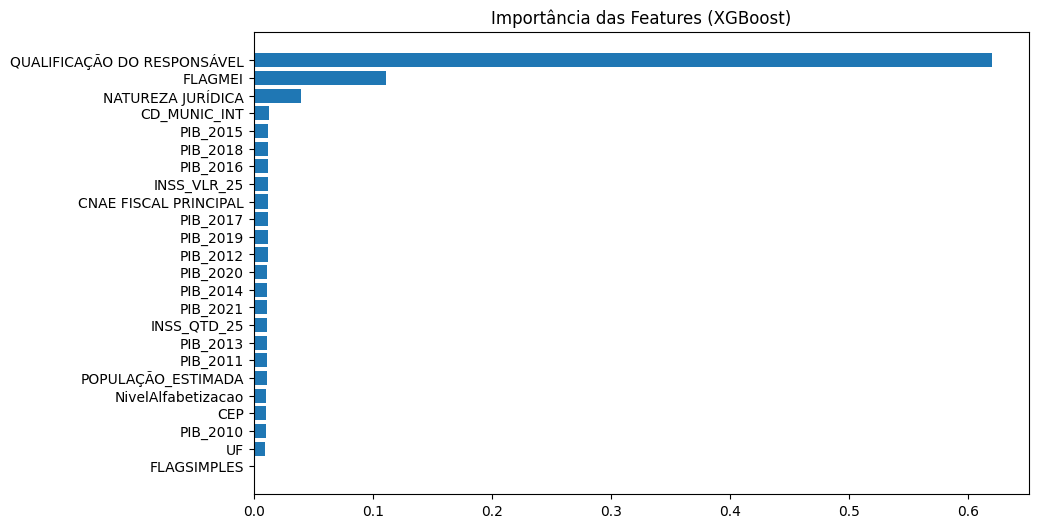

: 

In [ ]:
plt.figure(figsize=(10, 6))
plt.barh(feat_importance['Feature'], feat_importance['Importance'])
plt.gca().invert_yaxis()
plt.title('Importância das Features (XGBoost)')
plt.show()
